In [1]:
import autograd.numpy as np
np.set_printoptions(precision=2)
import matplotlib.pyplot as plt
%matplotlib inline

import pymanopt
from pymanopt.manifolds import Product, Euclidean,  Grassmann
from pymanopt import Problem
from pymanopt.solvers import ConjugateGradient#, SteepestDescent

from scipy.io import loadmat # for loading .mat files
#import h5py # another way to load .mat files

import time
from sklearn import decomposition, preprocessing
from sklearn import manifold

import math

import torch

from sklearn.metrics.cluster import normalized_mutual_info_score
import sklearn
from sklearn.cluster import KMeans



In [2]:
# set parameters

num_triplets=int(1e3)
alpha=45
lamb=1

init_dim=100

print(alpha,lamb,num_triplets,np.finfo(float).eps)

#print(np.random.permutation(100)[:3])

45 1 1000 2.220446049250313e-16


In [3]:

#load(['../data_DML/data_DML_' dataset]);
#load(['../data_DML/aaslabels/data_DML_' dataset '_aaslabels']);

data_dir='../data_DML/'
dataset='FashMNIST_tSNE' #JHMDB_tSNE,HMDB_ResNet152_tSNE,AwA_CUB_tSNE,FashMNIST_tSNE

filename=data_dir+'data_DML_'+dataset+'.mat'

#print(filename)


annots = loadmat(filename)
print(annots.keys())

#h5_f = h5py.File(filename,'r')
#data = f.get('data/variable1')
#data = np.array(data) # For converting to a NumPy array
#f.close()

print(type(annots['data_tr']), annots['data_tr'].shape)

data_tr=annots['data_tr'] # dxN
data_tst=annots['data_tst']

npair_constraints=annots['npair_constraints'] #Pxt: P: #N-pair tuples
truelabels_tr=annots['truelabels_tr'] # Nx1
truelabels_tst=annots['truelabels_tst']

print(data_tr.shape,data_tst.shape,npair_constraints.shape,truelabels_tr.shape,truelabels_tst.shape)


dict_keys(['__header__', '__version__', '__globals__', 'data_tr', 'data_tst', 'data_val', 'difPairInds', 'npair_constraints', 'points', 'simPairInds', 'triplets', 'truelabels_tr', 'truelabels_tst', 'truelabels_val'])
<class 'numpy.ndarray'> (784, 1750)
(784, 1750) (784, 1000) (384, 9) (1750, 1) (1000, 1)


In [4]:
num_tr=data_tr.shape[1] # num of training egs
suml_triplets=np.random.permutation(num_tr)[:3]
for i in range(num_triplets-1):
    suml_triplets=np.vstack((suml_triplets,np.random.permutation(num_tr)[:3]))

print(suml_triplets, suml_triplets.shape)


[[1210 1611 1450]
 [ 253 1449 1248]
 [1366 1140  440]
 ...
 [ 751 1259  297]
 [1134 1711 1352]
 [1522 1376 1454]] (1000, 3)


In [5]:
def get_pca(data, n_components = 2): #data: Nxd
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data) 
    return pca_data, pca.components_ # Nxl, (l, d) : l<=d

def plot_representations(data, labels, n_images = None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'tab10')
    handles, labels = scatter.legend_elements()
    legend = ax.legend(handles = handles, labels = labels)
    
def get_tsne(data, n_components = 2, n_images = None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

(784, 1750) (784, 1000)
[1. 1. 1. ... 1. 1. 1.]
[[1 1 1 ... 0 0 0]]
time elapsed for tSNE: 9.44399881362915


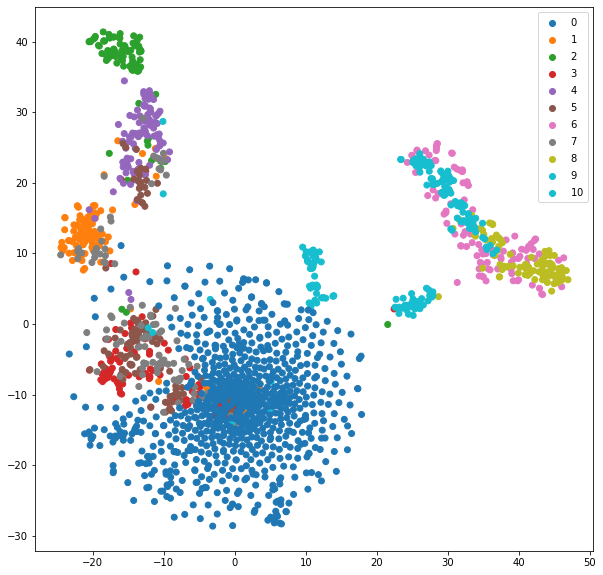

In [6]:
## Uncomment next few lines to apply PCA before running 
########### Begin PCA ###########
# t1=time.time()

# data_tr, pca_components_= get_pca(data_tr.T, n_components = init_dim) # pass Nxd, get Nxd
# data_tr =data_tr.T # lxN
# data_tst = pca_components_@data_tst #(l,d)x(dxN): (lxN)
# #print(pca_components_@pca_components_.T,data_tst)


# print('time elapsed for PCA:', time.time()-t1)
# del t1
########### End PCA ###########


# Apply l2-normalization on data
data_tr=preprocessing.normalize(data_tr.T, norm='l2').T
data_tst=preprocessing.normalize(data_tst.T, norm='l2').T

print(data_tr.shape, data_tst.shape)

print(np.sqrt(np.sum(data_tr*data_tr, axis=0)))

print(truelabels_tr.T)


# Visualize data using tSNE
t1=time.time()
plot_representations(get_tsne(data_tr.T), truelabels_tr.T)
print('time elapsed for tSNE:', time.time()-t1)
del t1


In [7]:
orig_dim=data_tr.shape[0]
latent_dim=64 # dimensionality of the latent space

manifold = Product([Euclidean(2*orig_dim, orig_dim), Euclidean(orig_dim, latent_dim)]) #list or tuples
#manifold = Product([Grassmann(orig_dim, latent_dim)]) #list or tuples


In [8]:
## debugging block

# Z=np.array([[1,2,3,4,5,6],[7,8,9,10,11,12]])

# inds=np.array([0,2,4,1,3,5,0,2,4,1,3,5,0,2,4,1,3,5])
# inds=inds.reshape(len(inds),)
# #inds=inds.T

# print(Z, Z.shape,inds,inds.shape, type(Z),type(inds))

# ancs=Z[:,inds]
# #ancs=ancs.reshape(ancs.shape[0],ancs.shape[1])
# print(ancs,ancs.shape,type(ancs))

#1/np.array([1,2,4,5,10])

In [9]:

@pymanopt.function.Autograd # 
#@pymanopt.function.Callable # reqd if egrad provided
def cost(S,L):
    #global alpha lamb #c
    #global npair_constraints data_tr rpml_triplets

    #S=np.random.rand(2*orig_dim,orig_dim)
    #L=np.random.rand(orig_dim,latent_dim)

    
    Z=data_tr
    #print(Z)

    num_triplets=suml_triplets.shape[0];

    anc_inds=suml_triplets[:,0:1]
    pos_inds=suml_triplets[:,1:2]
    neg_inds=suml_triplets[:,2:3]

    anc_inds=anc_inds.reshape(len(anc_inds),)
    pos_inds=pos_inds.reshape(len(pos_inds),)
    neg_inds=neg_inds.reshape(len(neg_inds),)

    #print(Z.shape,type(Z),anc_inds.shape,type(anc_inds),pos_inds.shape,neg_inds.shape)

    #a[[0, 1, 3], :]    
    #tmp_mt=tst_mt[np.ix_([0,2,5],[1,3])] 

    xi_ancs=Z[:,anc_inds] # dxT
    xi_poss=Z[:,pos_inds] # dxT
    xi_negs=Z[:,neg_inds] # dxT

    ############################################################################################################
    

    ## Case 3 a=p~=n

    ca_is= np.vstack((xi_ancs, xi_ancs)) # (2d)xT
    cp_is= np.vstack((xi_ancs, xi_poss)) # (2d)xT
    cn_is= np.vstack((xi_ancs, xi_negs)) # (2d)xT


    cm_is=(ca_is+cp_is)/2 # (2d)xT

    del_nm=cn_is-cm_is
    del_ap=ca_is-cp_is

    del_nm_S=S.T@del_nm # (d)xT
    del_ap_S=S.T@del_ap # (d)xT

    del_nm_SMh=L.T@del_nm_S # (d)xT
    del_ap_SMh=L.T@del_ap_S # (d)xT

    d_nms=np.sum(del_nm_S*del_nm_S,axis=0) #(T,)
    d_nms=d_nms.reshape(1,len(d_nms))  #1xT
    d_nms_Mh=np.sum(del_nm_SMh*del_nm_SMh,axis=0) # (T,)
    d_nms_Mh=d_nms_Mh.reshape(1,len(d_nms_Mh)) #1xT

    d_aps=np.sum(del_ap_S*del_ap_S,axis=0) #(T,)
    d_aps=d_aps.reshape(1,len(d_aps))  #1xT
    d_aps_Mh=np.sum(del_ap_SMh*del_ap_SMh,axis=0) # (T,)
    d_aps_Mh=d_aps_Mh.reshape(1,len(d_aps_Mh)) #1xT

    tan_sq_alpha=(math.tan(math.radians(alpha)))**2 # for angular 

    f_is_s=4*tan_sq_alpha*d_nms-d_aps # synthetic losses
    f_is_m=d_aps_Mh-4*tan_sq_alpha*d_nms_Mh # metric losses

    f_is_s=f_is_s/np.max(f_is_s)  # normalizing so that values don't grow too much
    f_is_m=f_is_m/np.max(f_is_m)
    
    p_i_3=(1/(1+np.exp(np.log(1+np.exp(f_is_s))+np.log(1+np.exp(f_is_m)))))+np.finfo(float).eps
    term3=np.sum(-p_i_3*np.log(p_i_3))
    
    ############################################################################################################
    
    ## Case 4 a=n~=p

    ca_is= np.vstack((xi_ancs, xi_ancs)) # (2d)xT
    cp_is= np.vstack((xi_ancs, xi_negs)) # (2d)xT
    cn_is= np.vstack((xi_ancs, xi_poss)) # (2d)xT


    cm_is=(ca_is+cp_is)/2 # (2d)xT

    del_nm=cn_is-cm_is
    del_ap=ca_is-cp_is

    del_nm_S=S.T@del_nm # (d)xT
    del_ap_S=S.T@del_ap # (d)xT

    del_nm_SMh=L.T@del_nm_S # (d)xT
    del_ap_SMh=L.T@del_ap_S # (d)xT

    d_nms=np.sum(del_nm_S*del_nm_S,axis=0) #(T,)
    d_nms=d_nms.reshape(1,len(d_nms))  #1xT
    d_nms_Mh=np.sum(del_nm_SMh*del_nm_SMh,axis=0) # (T,)
    d_nms_Mh=d_nms_Mh.reshape(1,len(d_nms_Mh)) #1xT

    d_aps=np.sum(del_ap_S*del_ap_S,axis=0) #(T,)
    d_aps=d_aps.reshape(1,len(d_aps))  #1xT
    d_aps_Mh=np.sum(del_ap_SMh*del_ap_SMh,axis=0) # (T,)
    d_aps_Mh=d_aps_Mh.reshape(1,len(d_aps_Mh)) #1xT

    tan_sq_alpha=(math.tan(math.radians(alpha)))**2 # for angular 

    f_is_s=4*tan_sq_alpha*d_nms-d_aps # synthetic losses
    f_is_m=d_aps_Mh-4*tan_sq_alpha*d_nms_Mh # metric losses
    
    f_is_s=f_is_s/np.max(f_is_s)  # normalizing so that values don't grow too much
    f_is_m=f_is_m/np.max(f_is_m)

    p_i_4=(1/(1+np.exp(np.log(1+np.exp(f_is_s))+np.log(1+np.exp(f_is_m)))))+np.finfo(float).eps
    term4=np.sum(-p_i_4*np.log(p_i_4))
    
    ############################################################################################################
    
    ## Case 5 p=n~=a

    ca_is= np.vstack((xi_poss, xi_poss)) # (2d)xT
    cp_is= np.vstack((xi_poss, xi_negs)) # (2d)xT
    cn_is= np.vstack((xi_poss, xi_ancs)) # (2d)xT


    cm_is=(ca_is+cp_is)/2 # (2d)xT

    del_nm=cn_is-cm_is
    del_ap=ca_is-cp_is

    del_nm_S=S.T@del_nm # (d)xT
    del_ap_S=S.T@del_ap # (d)xT

    del_nm_SMh=L.T@del_nm_S # (d)xT
    del_ap_SMh=L.T@del_ap_S # (d)xT

    d_nms=np.sum(del_nm_S*del_nm_S,axis=0) #(T,)
    d_nms=d_nms.reshape(1,len(d_nms))  #1xT
    d_nms_Mh=np.sum(del_nm_SMh*del_nm_SMh,axis=0) # (T,)
    d_nms_Mh=d_nms_Mh.reshape(1,len(d_nms_Mh)) #1xT

    d_aps=np.sum(del_ap_S*del_ap_S,axis=0) #(T,)
    d_aps=d_aps.reshape(1,len(d_aps))  #1xT
    d_aps_Mh=np.sum(del_ap_SMh*del_ap_SMh,axis=0) # (T,)
    d_aps_Mh=d_aps_Mh.reshape(1,len(d_aps_Mh)) #1xT

    tan_sq_alpha=(math.tan(math.radians(alpha)))**2 # for angular 

    f_is_s=4*tan_sq_alpha*d_nms-d_aps # synthetic losses
    f_is_m=d_aps_Mh-4*tan_sq_alpha*d_nms_Mh # metric losses
    
    f_is_s=f_is_s/np.max(f_is_s)  # normalizing so that values don't grow too much
    f_is_m=f_is_m/np.max(f_is_m)

    p_i_5=(1/(1+np.exp(np.log(1+np.exp(f_is_s))+np.log(1+np.exp(f_is_m)))))+np.finfo(float).eps
    term5=np.sum(-p_i_5*np.log(p_i_5))
    
    ############################################################################################################
    
    ## Case 1 a=p=n

    ca_is= np.vstack((xi_ancs, xi_poss)) # (2d)xT
    cp_is= np.vstack((xi_ancs, xi_negs)) # (2d)xT
    
    del_ap=ca_is-cp_is
    del_ap_S=S.T@del_ap # (d)xT
    del_ap_SMh=L.T@del_ap_S # (d)xT
    
    d_aps=np.sum(del_ap_S*del_ap_S,axis=0) #(T,)
    d_aps=d_aps.reshape(1,len(d_aps))  #1xT
    d_aps_Mh=np.sum(del_ap_SMh*del_ap_SMh,axis=0) # (T,)
    d_aps_Mh=d_aps_Mh.reshape(1,len(d_aps_Mh)) #1xT
    
    d_aps=d_aps/np.max(d_aps)  # normalizing so that values don't grow too much
    d_aps_Mh=d_aps_Mh/np.max(d_aps_Mh)

    p_i_1=(1/(1+np.exp(-d_aps+d_aps_Mh)))+np.finfo(float).eps
    term1=np.sum(-p_i_1*np.log(p_i_1))

    ############################################################################################################
    
    ## Case 2 a~=p~=n

    ca_is= np.vstack((xi_ancs, xi_poss)) # (2d)xT
    cn_is= np.vstack((xi_ancs, xi_negs)) # (2d)xT

    del_an=ca_is-cn_is
    del_an_S=S.T@del_an # (d)xT
    del_an_SMh=L.T@del_an_S # (d)xT

    d_ans=np.sum(del_an_S*del_an_S,axis=0) #(T,)
    d_ans=d_ans.reshape(1,len(d_ans))  #1xT
    d_ans_Mh=np.sum(del_an_SMh*del_an_SMh,axis=0) # (T,)
    d_ans_Mh=d_ans_Mh.reshape(1,len(d_ans_Mh)) #1xT
    
    d_ans=d_ans/np.max(d_ans)  # normalizing so that values don't grow too much
    d_ans_Mh=d_ans_Mh/np.max(d_ans_Mh)

    p_i_2=(1/(1+np.exp(d_ans-d_ans_Mh)))+np.finfo(float).eps
    term2=np.sum(-p_i_2*np.log(p_i_2))
    
    
    ############################################################################################################
    
    #denom1=(np.linalg.norm(L.T@L, 'fro'))**2
    denom=10*num_triplets
    J_reg = (lamb/denom)*(np.linalg.norm(L.T@L-np.identity((L.T@L).shape[0]), 'fro'))**2
    
    
    ############################################################################################################

    objective= (1/num_triplets)*(term3+term4+term5+term1+term2)+J_reg
    
    ############################################################################################################
    
    return objective
    

In [10]:
# @pymanopt.function.Callable
# def egrad(S,L):

    
    
#     return euc_grad_R, euc_grad_L

In [11]:

problem = Problem(manifold=manifold, cost=cost)

# (3) Instantiate a Pymanopt solver
solver = ConjugateGradient( maxiter=30 , logverbosity=2)

# let Pymanopt do the rest
Xopt, optlog = solver.solve(problem)

Optimizing...
 iter		   cost val	    grad. norm
    0	+4.2660646303395524e+03	7.88780495e+01
    1	+4.1877631041825325e+03	7.77273519e+01
    2	+4.0367823975986257e+03	7.54975179e+01
    3	+3.7558200346713770e+03	7.13070358e+01
    4	+3.2673765012002555e+03	6.38811181e+01
    5	+2.5182657597717343e+03	5.20679115e+01
    6	+1.5913296573529640e+03	3.64314141e+01
    7	+7.6307551747096909e+02	2.07173098e+01
    8	+2.7261900458435366e+02	9.48379031e+00
    9	+7.8977988430551889e+01	3.70107659e+00
   10	+2.1565453505521159e+01	1.33971305e+00
   11	+6.6345399775517713e+00	4.78628306e-01
   12	+2.8326262791251482e+00	1.78097967e-01
   13	+1.9032390067820029e+00	6.52951486e-02
   14	+1.6627851407102983e+00	5.32113570e-02
   15	+1.6385862254111336e+00	2.22163989e-02
   16	+1.6274803619035147e+00	1.74000100e-02
   17	+1.6138639475202821e+00	1.39215657e-02
   18	+1.5987739041019453e+00	1.06589731e-02
   19	+1.5833763223881201e+00	8.10220013e-03
   20	+1.5776199859153937e+00	1.13102319e-02
   21	+

In [12]:
print(type(Xopt),type(optlog))

#print(Xopt.shape,optlog.shape)

#print(Xopt,optlog)


<class 'list'> <class 'dict'>


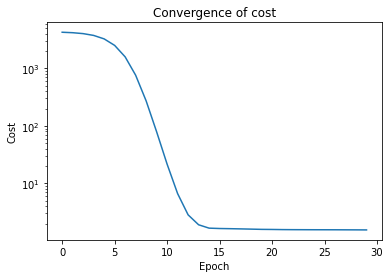

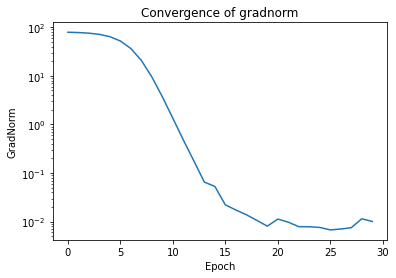

In [13]:
# print(optlog.keys())

# print(optlog['iterations']['iteration'])
# print(optlog['iterations']['f(x)'])
# print(optlog['iterations']['gradnorm'])


plt.semilogy(optlog['iterations']['iteration'], optlog['iterations']['f(x)'])    
plt.title('Convergence of cost') 
plt.xlabel('Epoch') 
plt.ylabel('Cost') 
plt.show() 


plt.semilogy(optlog['iterations']['iteration'], optlog['iterations']['gradnorm'])    
plt.title('Convergence of gradnorm') 
plt.xlabel('Epoch') 
plt.ylabel('GradNorm') 
plt.show()


In [14]:
S=Xopt[0]
L=Xopt[1]

#print(L.shape,L)
#print((L.T@L).shape,L.T@L)

#Mh = sqrtm(M)
#proj_matrix=Mh*L'
proj_matrix=L.T


In [15]:
# Nearest Neighbor (NN) search and recall computation
# nn search and recall computation
def recall(embeddings, labels, K = 1): # embeddings: Nxd
    prod = torch.mm(embeddings, embeddings.t())
    norm = prod.diag().unsqueeze(1).expand_as(prod)
    D = norm + norm.t() - 2 * prod
    knn_inds = D.topk(1 + K, dim = 1, largest = False)[1][:, 1:]
    
#     print(type(embeddings),type(labels),type(prod),type(norm),type(D),type(knn_inds))
#     print(embeddings.size(),labels.size(),prod.size(),norm.size(),D.size(),knn_inds.size())
    
    #return (labels.unsqueeze(-1).expand_as(knn_inds) == labels[knn_inds.contiguous().view(-1)].view_as(knn_inds)).max(1)[0].float().mean()
    return (labels == labels[knn_inds.contiguous().view(-1)].view_as(knn_inds)).max(1)[0].float().mean()


In [16]:
def eval_nmi(embedding, label,  normed_flag = False, fast_kmeans = False): # provide Nxd data, (N,) labels
    unique_id = np.unique(label)
    num_category = len(unique_id)
    if normed_flag:
        for i in range(embedding.shape[0]):
            embedding[i,:] = embedding[i,:]/np.sqrt(np.sum(embedding[i,:] ** 2)+1e-4)
    if fast_kmeans:
        kmeans = KMeans(n_clusters=num_category, n_init = 1, n_jobs=8)
    else:
        kmeans = KMeans(n_clusters=num_category,n_jobs=8)
    kmeans.fit(embedding)
    y_kmeans_pred = kmeans.predict(embedding)
    nmi = normalized_mutual_info_score(label, y_kmeans_pred)
    return nmi

In [17]:
proj_data_tst=proj_matrix@data_tst

#print(proj_data_tst.shape,data_tst.shape)

#print(torch.Tensor(proj_data_tst.T),torch.Tensor(truelabels_tst.T))


In [18]:
k_arr=[1,2,4,8]

rec = [ recall(torch.Tensor(proj_data_tst.T), torch.Tensor(list(truelabels_tst)), x).item() for x in k_arr ]


nmi = eval_nmi(proj_data_tst.T, truelabels_tst.reshape(len(truelabels_tst),)) # provide Nxd data, (N,) labels
print('NMI Recall@1,2,4,8 : {:.06f} {:.06f} {:.06f} {:.06f} {:.06f}'.format(nmi, rec[0], rec[1], rec[2], rec[3]))



NMI Recall@1,2,4,8 : 0.636877 0.753000 0.847000 0.897000 0.934000


/opt/anaconda3/envs/py36pt100/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
